# Introduction

EDA of flights scheduled to arrive at ATL airport in 2017 and 2018.

# Set up Environment

In [229]:
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go
from scipy.stats import pearsonr
import warnings
import pandas as pd
import matplotlib.pyplot as plt

# be able to view all columns of dataframes
pd.options.display.max_columns = None

# ignore warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
data_folder = '../data/raw/training_data/'
df = pd.read_csv(data_folder + 'training_data_ATL.zip')

# Process

In [3]:
# remove the Unnamed column
df.drop(df.columns[df.columns.str.contains(
    'unnamed', case=False)], axis=1, inplace=True)

# ignore airport traffic data as of now
feature_list = ['Num_Arr_SLDT-30', 'Num_Arr_SLDT-25', 'Num_Arr_SLDT-20', 'Num_Arr_SLDT-15', 'Num_Arr_SLDT-10',
                'Num_Arr_SLDT-5', 'Num_Arr_SLDT-0', 'Num_Arr_SLDT+5', 'Num_Arr_SLDT+10', 'Num_Arr_SLDT+15',
                'Num_Arr_SLDT+20', 'Num_Arr_SLDT+25', 'Num_Dep_SLDT-30', 'Num_Dep_SLDT-25', 'Num_Dep_SLDT-20',
                'Num_Dep_SLDT-15', 'Num_Dep_SLDT-10', 'Num_Dep_SLDT-5', 'Num_Dep_SLDT-0', 'Num_Dep_SLDT+5',
                'Num_Dep_SLDT+10', 'Num_Dep_SLDT+15', 'Num_Dep_SLDT+20', 'Num_Dep_SLDT+25']

arrivals = df.copy()
for feature in feature_list:
    arrivals = arrivals.drop(labels=feature, axis=1)

In [4]:
arrivals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744979 entries, 0 to 744978
Data columns (total 60 columns):
Year                               744979 non-null int64
Quarter                            744979 non-null int64
Month                              744979 non-null int64
DayofMonth                         744979 non-null int64
DayOfWeek                          744979 non-null int64
FlightDate                         744979 non-null object
Reporting_Airline                  744979 non-null object
DOT_ID_Reporting_Airline           744979 non-null int64
IATA_CODE_Reporting_Airline        744979 non-null object
Tail_Number                        744979 non-null object
Flight_Number_Reporting_Airline    744979 non-null int64
OriginAirportID                    744979 non-null int64
OriginAirportSeqID                 744979 non-null int64
OriginCityMarketID                 744979 non-null int64
Origin                             744979 non-null object
OriginCityName               

In [7]:
# obtain a segment of arrivals (intersted columns)
segment = arrivals[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate', 'ArrivalDate',
                    'Reporting_Airline', 'OriginAirportID', 'OriginCityName', 'OriginStateName',
                    'CRSDepTime', 'DepTime', 'DepDelay', 'DepDel15', 'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOut',
                    'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTime', 'ArrDelay', 'ArrDel15',
                    'ArrivalDelayGroups', 'ArrTimeBlk', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime',
                    'Distance', 'DistanceGroup', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
                    'LateAircraftDelay']]

In [8]:
segment.head(3)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,ArrivalDate,Reporting_Airline,OriginAirportID,OriginCityName,OriginStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2017,1,1,1,7,2017-01-01 00:00:00,2017-01-01 00:00:00,AA,11298,"Dallas/Fort Worth, TX",Texas,14:25:00,1430.0,5.0,0.0,0.0,1400-1459,12.0,1442.0,1717.0,10.0,17:26:00,1727.0,1.0,0.0,0.0,1700-1759,121.0,117.0,95.0,731.0,3,NaN,NaN,NaN,NaN,NaN
1,2017,1,1,2,1,2017-01-02 00:00:00,2017-01-02 00:00:00,AA,11298,"Dallas/Fort Worth, TX",Texas,14:25:00,1420.0,-5.0,0.0,-1.0,1400-1459,13.0,1433.0,1723.0,11.0,17:26:00,1734.0,8.0,0.0,0.0,1700-1759,121.0,134.0,110.0,731.0,3,NaN,NaN,NaN,NaN,NaN
2,2017,1,1,3,2,2017-01-03 00:00:00,2017-01-03 00:00:00,AA,11298,"Dallas/Fort Worth, TX",Texas,14:25:00,1426.0,1.0,0.0,0.0,1400-1459,14.0,1440.0,1718.0,5.0,17:26:00,1723.0,-3.0,0.0,-1.0,1700-1759,121.0,117.0,98.0,731.0,3,NaN,NaN,NaN,NaN,NaN


In [12]:
# rename some column names
segment = segment.rename(columns={'DayOfWeek': 'DayofWeek',
                                  'FlightDate': 'SOBTDate',
                                  'ArrivalDate': 'SIBTDate',
                                  'Reporting_Airline': 'UniqueCarrierCode',
                                  'CRSDepTime': 'SOBTTime',
                                  'DepTime': 'AOBTTime',
                                  'DepDelay': 'OBTDelay',
                                  'DepDel15': 'OBTDel15',
                                  'DepartureDelayGroups': 'OBTDelayGroups',
                                  'DepTimeBlk': 'OBTTimeBlk',
                                  'TaxiOut': 'AXOT',
                                  'WheelsOff': 'ATOTTime',
                                  'WheelsOn': 'ALDTTime',
                                  'TaxiIn': 'AXIT',
                                  'CRSArrTime': 'SIBTTime',
                                  'ArrTime': 'AIBTTime',
                                  'ArrDelay': 'IBTDelay',
                                  'ArrDel15': 'IBTDel15',
                                  'ArrivalDelayGroups': 'IBTDelayGroups',
                                  'ArrTimeBlk': 'IBTTimeBlk',
                                  'CRSElapsedTime': 'SOBTtoSIBT',
                                  'ActualElapsedTime': 'AOBTtoAIBT',
                                  'AirTime': 'AirborneTime'})

In [13]:
# convert scheduled times to datetime objects
date_list = ['SOBTDate', 'SIBTDate']
for date in date_list:
    segment[date] = segment[date].apply(lambda x: pd.to_datetime(x)).dt.date

timing_list = ['SOBTTime', 'SIBTTime']
for timing in timing_list:
    segment[timing] = segment[timing].apply(
        lambda x: pd.to_datetime(x, format='%H:%M:%S')).dt.time

In [15]:
timing_list = ['AOBTTime', 'ATOTTime', 'ALDTTime', 'AIBTTime']

for timing in timing_list:
    segment[timing] = segment[timing].apply(lambda x: str(int(x)).zfill(4))

max(segment['AOBTTime'])
# '2400'cannot be handled by pd.to_datetime()

'2400'

In [17]:
# analyze why '2400' were produced
segment[segment['AOBTTime'] == '2400'].head(3)

# '2400' was produced only for actual timings. Scheduled timings will not have this issue
# when the actual timings is 2400, the date change to the next day, but wasn't reflected in the row
# for e.g. 2400 1 Jan == 0000 2 Jan

,Year,Quarter,Month,DayofMonth,DayofWeek,SOBTDate,SIBTDate,UniqueCarrierCode,OriginAirportID,OriginCityName,OriginStateName,SOBTTime,AOBTTime,OBTDelay,OBTDel15,OBTDelayGroups,OBTTimeBlk,AXOT,ATOTTime,ALDTTime,AXIT,SIBTTime,AIBTTime,IBTDelay,IBTDel15,IBTDelayGroups,IBTTimeBlk,SOBTtoSIBT,AOBTtoAIBT,AirborneTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
33760,2017,4,10,2,1,2017-10-02,2017-10-03,DL,14771,"San Francisco, CA",California,23:55:00,2400,5.0,0.0,0.0,2300-2359,17.0,0017,0703,10.0,07:21:00,0713,-8.0,0.0,-1.0,0700-0759,266.0,253.0,226.0,2139.0,9,NaN,NaN,NaN,NaN,NaN
48345,2017,4,10,20,5,2017-10-20,2017-10-21,DL,12889,"Las Vegas, NV",Nevada,23:56:00,2400,4.0,0.0,0.0,2300-2359,16.0,0016,0629,7.0,06:35:00,0636,1.0,0.0,0.0,0600-0659,219.0,216.0,193.0,1747.0,7,NaN,NaN,NaN,NaN,NaN
65078,2017,4,11,23,4,2017-11-23,2017-11-24,DL,14869,"Salt Lake City, UT",Utah,23:59:00,2400,1.0,0.0,0.0,2300-2359,48.0,0048,0544,7.0,05:36:00,0551,15.0,1.0,1.0,0001-0559,217.0,231.0,176.0,1590.0,7,0.0,0.0,15.0,0.0,0.0


In [19]:
one_day = pd.Timedelta('1 days')

# Initialize AOBTDate
segment['AOBTDate'] = segment['SOBTDate']

# if 2400 occurs, add 1 day to AOBTDate
segment.loc[segment.AOBTTime == '2400', "AOBTDate"] = segment['AOBTDate'] + one_day

# update AOBTTime from '2400' to '0000'
segment.loc[segment.AOBTTime == '2400', "AOBTTime"] = '0000'

In [20]:
segment[segment['ATOTTime'] == '2400'].head(3)

,Year,Quarter,Month,DayofMonth,DayofWeek,SOBTDate,SIBTDate,UniqueCarrierCode,OriginAirportID,OriginCityName,OriginStateName,SOBTTime,AOBTTime,OBTDelay,OBTDel15,OBTDelayGroups,OBTTimeBlk,AXOT,ATOTTime,ALDTTime,AXIT,SIBTTime,AIBTTime,IBTDelay,IBTDel15,IBTDelayGroups,IBTTimeBlk,SOBTtoSIBT,AOBTtoAIBT,AirborneTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,AOBTDate
4734,2017,1,1,29,7,2017-01-29,2017-01-29,DL,11057,"Charlotte, NC",North Carolina,19:45:00,2341,236.0,1.0,12.0,1900-1959,19.0,2400,0041,10.0,21:11:00,0051,220.0,1.0,12.0,2100-2159,86.0,70.0,41.0,226.0,1,217.0,0.0,0.0,0.0,3.0,2017-01-29
4749,2017,1,1,29,7,2017-01-29,2017-01-29,DL,15412,"Knoxville, TN",Tennessee,19:16:00,2350,274.0,1.0,12.0,1900-1959,10.0,2400,0029,11.0,20:30:00,0040,250.0,1.0,12.0,2000-2059,74.0,50.0,29.0,152.0,1,250.0,0.0,0.0,0.0,0.0,2017-01-29
7270,2017,1,1,8,7,2017-01-08,2017-01-09,DL,12892,"Los Angeles, CA",California,23:35:00,2341,6.0,0.0,0.0,2300-2359,19.0,2400,0631,10.0,06:47:00,0641,-6.0,0.0,-1.0,0600-0659,252.0,240.0,211.0,1946.0,8,NaN,NaN,NaN,NaN,NaN,2017-01-08


In [21]:
segment['ATOTDate'] = segment['SOBTDate']
segment.loc[segment.ATOTTime == '2400', "ATOTDate"] = segment['ATOTDate'] + one_day
segment.loc[segment.ATOTTime == '2400', "ATOTTime"] = '0000'

In [23]:
segment[segment['ALDTTime'] == '2400'].head(3)

,Year,Quarter,Month,DayofMonth,DayofWeek,SOBTDate,SIBTDate,UniqueCarrierCode,OriginAirportID,OriginCityName,OriginStateName,SOBTTime,AOBTTime,OBTDelay,OBTDel15,OBTDelayGroups,OBTTimeBlk,AXOT,ATOTTime,ALDTTime,AXIT,SIBTTime,AIBTTime,IBTDelay,IBTDel15,IBTDelayGroups,IBTTimeBlk,SOBTtoSIBT,AOBTtoAIBT,AirborneTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,AOBTDate,ATOTDate
149,2017,1,1,16,1,2017-01-16,2017-01-16,AS,14747,"Seattle, WA",Washington,16:15:00,1618,3.0,0.0,0.0,1600-1659,18.0,1636,2400,7.0,23:59:00,0007,8.0,0.0,0.0,2300-2359,284.0,289.0,264.0,2182.0,9,NaN,NaN,NaN,NaN,NaN,2017-01-16,2017-01-16
6753,2017,1,1,23,1,2017-01-23,2017-01-23,WN,11278,"Washington, DC",Virginia,20:55:00,2230,95.0,1.0,6.0,2000-2059,14.0,2244,2400,8.0,22:55:00,0008,73.0,1.0,4.0,2200-2259,120.0,98.0,76.0,547.0,3,0.0,0.0,0.0,0.0,73.0,2017-01-23,2017-01-23
13357,2017,1,1,7,6,2017-01-07,2017-01-07,DL,11618,"Newark, NJ",New Jersey,16:45:00,2037,232.0,1.0,12.0,1600-1659,87.0,2204,2400,12.0,19:23:00,0012,289.0,1.0,12.0,1900-1959,158.0,215.0,116.0,746.0,3,0.0,15.0,57.0,0.0,217.0,2017-01-07,2017-01-07


In [24]:
segment['ALDTDate'] = segment['SIBTDate']
segment.loc[segment.ALDTTime == '2400', "ALDTDate"] = segment['ALDTDate'] + one_day
segment.loc[segment.ALDTTime == '2400', "ALDTTime"] = '0000'

In [25]:
segment[segment['AIBTTime'] == '2400'].head(3)

,Year,Quarter,Month,DayofMonth,DayofWeek,SOBTDate,SIBTDate,UniqueCarrierCode,OriginAirportID,OriginCityName,OriginStateName,SOBTTime,AOBTTime,OBTDelay,OBTDel15,OBTDelayGroups,OBTTimeBlk,AXOT,ATOTTime,ALDTTime,AXIT,SIBTTime,AIBTTime,IBTDelay,IBTDel15,IBTDelayGroups,IBTTimeBlk,SOBTtoSIBT,AOBTtoAIBT,AirborneTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,AOBTDate,ATOTDate,ALDTDate
12257,2017,1,1,1,7,2017-01-01,2017-01-01,AA,13303,"Miami, FL",Florida,21:43:00,2206,23.0,1.0,1.0,2100-2159,17.0,2223,2351,9.0,23:49:00,2400,11.0,0.0,0.0,2300-2359,126.0,114.0,88.0,594.0,3,NaN,NaN,NaN,NaN,NaN,2017-01-01,2017-01-01,2017-01-01
12268,2017,1,1,13,5,2017-01-13,2017-01-13,AA,13303,"Miami, FL",Florida,21:41:00,2201,20.0,1.0,1.0,2100-2159,24.0,2225,2351,9.0,23:42:00,2400,18.0,1.0,1.0,2300-2359,121.0,119.0,86.0,594.0,3,18.0,0.0,0.0,0.0,0.0,2017-01-13,2017-01-13,2017-01-13
13264,2017,1,1,7,6,2017-01-07,2017-01-07,DL,11433,"Detroit, MI",Michigan,20:18:00,2153,95.0,1.0,6.0,2000-2059,37.0,2230,2356,4.0,22:29:00,2400,91.0,1.0,6.0,2200-2259,131.0,127.0,86.0,594.0,3,86.0,0.0,0.0,0.0,5.0,2017-01-07,2017-01-07,2017-01-07


In [26]:
segment['AIBTDate'] = segment['SIBTDate']
segment.loc[segment.AIBTTime == '2400', "AIBTDate"] = segment['AIBTDate'] + one_day
segment.loc[segment.AIBTTime == '2400', "AIBTTime"] = '0000'

In [28]:
# now the issue of '2400' is resolved
# update timings to time objects
for timing in timing_list:
    segment[timing] = segment[timing].apply(
        lambda x: pd.to_datetime(x, format='%H%M')).dt.time

In [29]:
segment.head(3)

,Year,Quarter,Month,DayofMonth,DayofWeek,SOBTDate,SIBTDate,UniqueCarrierCode,OriginAirportID,OriginCityName,OriginStateName,SOBTTime,AOBTTime,OBTDelay,OBTDel15,OBTDelayGroups,OBTTimeBlk,AXOT,ATOTTime,ALDTTime,AXIT,SIBTTime,AIBTTime,IBTDelay,IBTDel15,IBTDelayGroups,IBTTimeBlk,SOBTtoSIBT,AOBTtoAIBT,AirborneTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,AOBTDate,ATOTDate,ALDTDate,AIBTDate
0,2017,1,1,1,7,2017-01-01,2017-01-01,AA,11298,"Dallas/Fort Worth, TX",Texas,14:25:00,14:30:00,5.0,0.0,0.0,1400-1459,12.0,14:42:00,17:17:00,10.0,17:26:00,17:27:00,1.0,0.0,0.0,1700-1759,121.0,117.0,95.0,731.0,3,NaN,NaN,NaN,NaN,NaN,2017-01-01,2017-01-01,2017-01-01,2017-01-01
1,2017,1,1,2,1,2017-01-02,2017-01-02,AA,11298,"Dallas/Fort Worth, TX",Texas,14:25:00,14:20:00,-5.0,0.0,-1.0,1400-1459,13.0,14:33:00,17:23:00,11.0,17:26:00,17:34:00,8.0,0.0,0.0,1700-1759,121.0,134.0,110.0,731.0,3,NaN,NaN,NaN,NaN,NaN,2017-01-02,2017-01-02,2017-01-02,2017-01-02
2,2017,1,1,3,2,2017-01-03,2017-01-03,AA,11298,"Dallas/Fort Worth, TX",Texas,14:25:00,14:26:00,1.0,0.0,0.0,1400-1459,14.0,14:40:00,17:18:00,5.0,17:26:00,17:23:00,-3.0,0.0,-1.0,1700-1759,121.0,117.0,98.0,731.0,3,NaN,NaN,NaN,NaN,NaN,2017-01-03,2017-01-03,2017-01-03,2017-01-03


In [30]:
# merge date & time
list_1 = ['SOBTDate', 'SIBTDate', 'AOBTDate',
          'ATOTDate', 'ALDTDate', 'AIBTDate']
list_2 = ['SOBTTime', 'SIBTTime', 'AOBTTime',
          'ATOTTime', 'ALDTTime', 'AIBTTime']
list_3 = ['SOBT', 'SIBT', 'AOBT', 'ATOT', 'ALDT', 'AIBT']

for i in range(6):
    segment[list_2[i]] = segment.apply(
        lambda r: pd.datetime.combine(r[list_1[i]], r[list_2[i]]), 1)
    segment = segment.drop(labels=list_1[i], axis=1)
    segment = segment.rename(columns={list_2[i]: list_3[i]})

In [31]:
# convert float to int
to_int = ['OBTDelay', 'OBTDel15', 'OBTDelayGroups', 'AXOT', 'AXIT', 'IBTDelay', 'IBTDel15', 'IBTDelayGroups',
          'SOBTtoSIBT', 'AOBTtoAIBT', 'AirborneTime', 'Distance', 'DistanceGroup', 'CarrierDelay', 'WeatherDelay',
          'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

for item in to_int:
    segment[item] = segment[item].fillna(0).apply(lambda x: int(x))
    segment[item] = segment[item].apply(lambda x: int(x))

In [35]:
# update Year, Quarter, Month, DayofMonth, DayofWeek based on SIBT (previously, SOBT)
segment['Year'] = segment['SIBT'].dt.year
segment['Quarter'] = segment['SIBT'].dt.quarter
segment['Month'] = segment['SIBT'].dt.month
segment['DayofMonth'] = segment['SIBT'].dt.day
segment['DayofWeek'] = segment['SIBT'].dt.weekday + 1

# update OBTTimeBlk and IBTTimeBlk based on SOBT and SIBT respectively
segment['OBTTimeBlk'] = segment['SOBT'].dt.hour
segment['IBTTimeBlk'] = segment['SIBT'].dt.hour

In [55]:
# as Year was updated based on SIBT, there are flights scheduled to arrive at ATL in 2019
# count how many such flights there are
segment[segment['Year']==2019]['Year'].count()

14

In [58]:
# remove these 14 flights as only arrival flights scheduled in 2017 and 2018 are of concern
segment = segment[segment['Year'] != 2019]

In [59]:
flights = segment.copy()

# Explore

In [200]:
flights_2017 = flights[flights['Year'] == 2017]
flights_2018 = flights[flights['Year'] == 2018]

print('Total number of arrivals in 2017 and 2018:', flights.shape[0])
print('Total number of arrivals in 2017:', flights_2017.shape[0])
print('Total number of arrivals in 2018:', flights_2018.shape[0])

Total number of arrivals in 2017 and 2018: 744965
Total number of arrivals in 2017: 358249
Total number of arrivals in 2018: 386716


## Airlines and origin airports

In [167]:
print('Arrival flights come from ' +
      str(len(flights['OriginAirportID'].unique())) + ' different airports.')
print('And they belong to these airlines: ')
print(flights['UniqueCarrierCode'].unique())

Arrival flights come from 168 different airports.
And they belong to these airlines: 
['AA' 'AS' 'DL' 'F9' 'NK' 'OO' 'UA' 'WN' 'EV' 'B6' '9E' 'MQ' 'OH' 'YV'
 'YX']


Text(0.5, 1.0, 'Number of arrivals by airline')

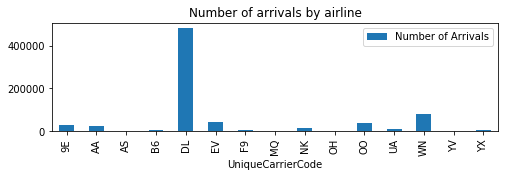

In [107]:
by_airline = flights.groupby(['UniqueCarrierCode'])[['Year']].count().rename(
    columns={'Year': 'Number of Arrivals'})
by_airline.plot.bar(y='Number of Arrivals', figsize=(8, 2))
plt.title('Number of arrivals by airline')

## Number of arrivals by state

Text(0.5, 1.0, 'Number of arrivals by state')

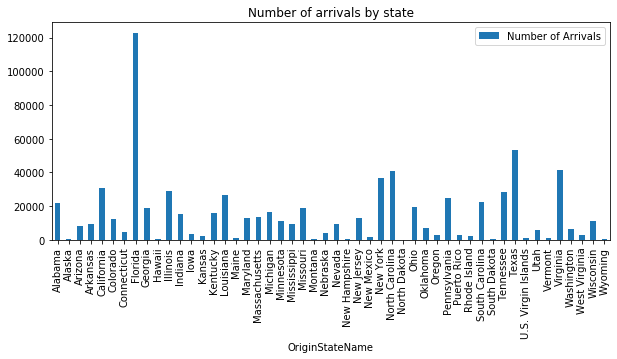

In [108]:
state_flights = flights.groupby(['OriginStateName'])[['Year']].count().rename(
    columns={'Year': 'Number of Arrivals'})
state_flights.plot.bar(figsize=(10, 4))
plt.title('Number of arrivals by state')

## Number of arrivals by month

Text(0.5, 1.0, 'Number of arrivals by month')

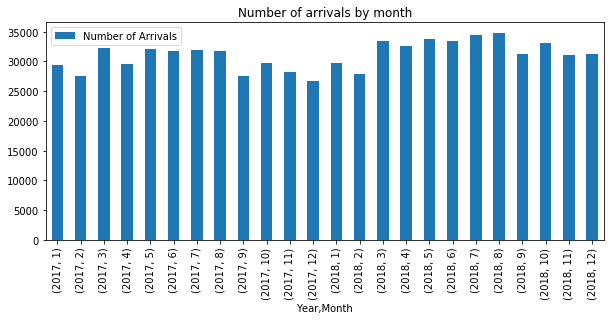

In [111]:
monthly_flights = flights.groupby(['Year', 'Month'])[['Year']].count().rename(
    columns={'Year': 'Number of Arrivals'})
monthly_flights.plot.bar(figsize=(10, 4))
plt.title('Number of arrivals by month')

## Number of arrivals by quarter

Text(0.5, 1.0, 'Number of arrivals by quarter')

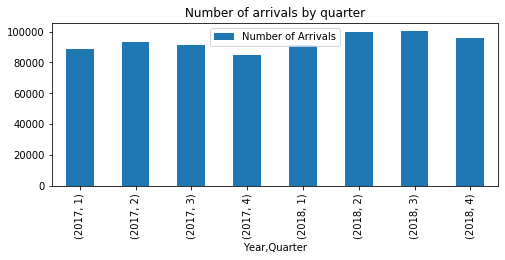

In [113]:
quarter_flights = flights.groupby(['Year', 'Quarter'])[['Year']].count().rename(
    columns={'Year': 'Number of Arrivals'})
quarter_flights.plot.bar(figsize=(8, 3))
plt.title('Number of arrivals by quarter')

## Number of arrivals by dayofmonth

Text(0.5, 1.0, 'Number of arrivals by dayofmonth')

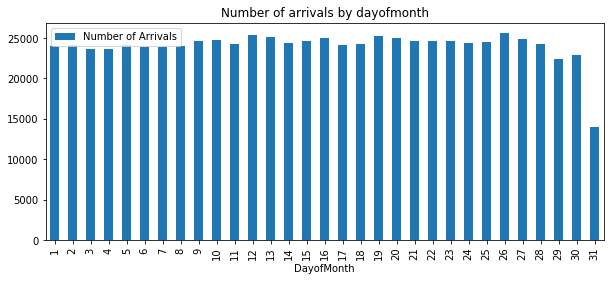

In [115]:
monthday_flights = flights.groupby(['DayofMonth'])[['Year']].count().rename(
    columns={'Year': 'Number of Arrivals'})
monthday_flights.plot.bar(figsize=(10, 4))
plt.title('Number of arrivals by dayofmonth')

## Number of arrivals by weekday

Text(0.5, 1.0, 'Number of arrivals by weekday')

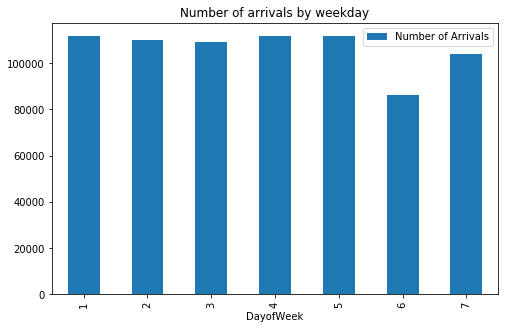

In [116]:
weekday_flights = flights.groupby(['DayofWeek'])[['Year']].count().rename(
    columns={'Year': 'Number of Arrivals'})
weekday_flights.plot.bar(figsize=(8, 5))
plt.title('Number of arrivals by weekday')

## Number of arrivals by IBTTimeBlk

Text(0.5, 1.0, 'Number of arrivals by IBTTimeBlk')

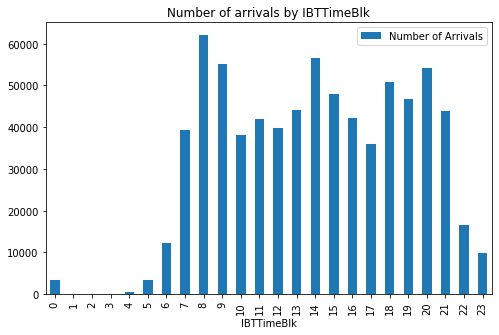

In [204]:
hourly_flights = flights.groupby(['IBTTimeBlk'])[['Year']].count().rename(
    columns={'Year': 'Number of Arrivals'})
hourly_flights.plot.bar(figsize=(8, 5))
plt.title('Number of arrivals by IBTTimeBlk')

## Delayed flights

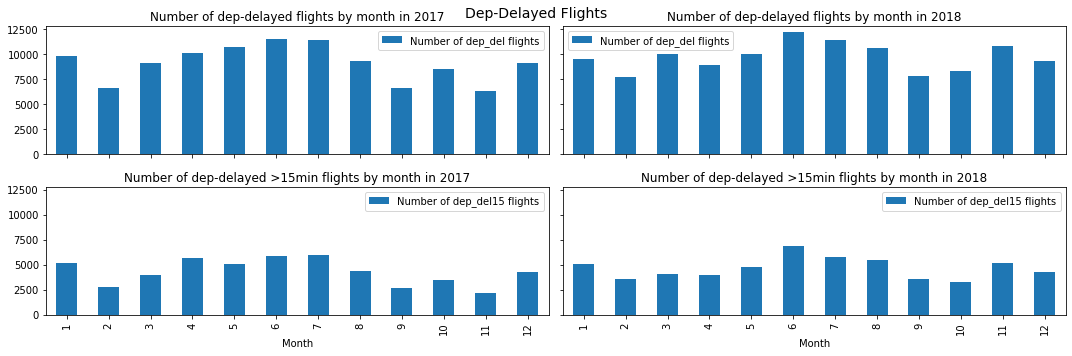

In [138]:
dep_del_count_2017 = flights_2017[flights_2017['OBTDelay'] > 0].groupby(['Month'])[['Year']].count().rename(
    columns={'Year': 'Number of dep_del flights'})
dep_del15_count_2017 = flights_2017[flights_2017['OBTDel15'] == 1].groupby(['Month'])[['Year']].count().rename(
    columns={'Year': 'Number of dep_del15 flights'})
dep_del_count_2018 = flights_2018[flights_2018['OBTDelay'] > 0].groupby(['Month'])[['Year']].count().rename(
    columns={'Year': 'Number of dep_del flights'})
dep_del15_count_2018 = flights_2018[flights_2018['OBTDel15'] == 1].groupby(['Month'])[['Year']].count().rename(
    columns={'Year': 'Number of dep_del15 flights'})

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(15, 5))
fig.suptitle('Dep-Delayed Flights', fontsize=14)
dep_del_count_2017.plot.bar(ax=axes[0, 0], subplots=True)
dep_del15_count_2017.plot.bar(ax=axes[1, 0], subplots=True)
dep_del_count_2018.plot.bar(ax=axes[0, 1], subplots=True)
dep_del15_count_2018.plot.bar(ax=axes[1, 1], subplots=True)

axes[0, 0].title.set_text('Number of dep-delayed flights by month in 2017')
axes[1, 0].title.set_text(
    'Number of dep-delayed >15min flights by month in 2017')
axes[0, 1].title.set_text('Number of dep-delayed flights by month in 2018')
axes[1, 1].title.set_text(
    'Number of dep-delayed >15min flights by month in 2018')

plt.tight_layout()

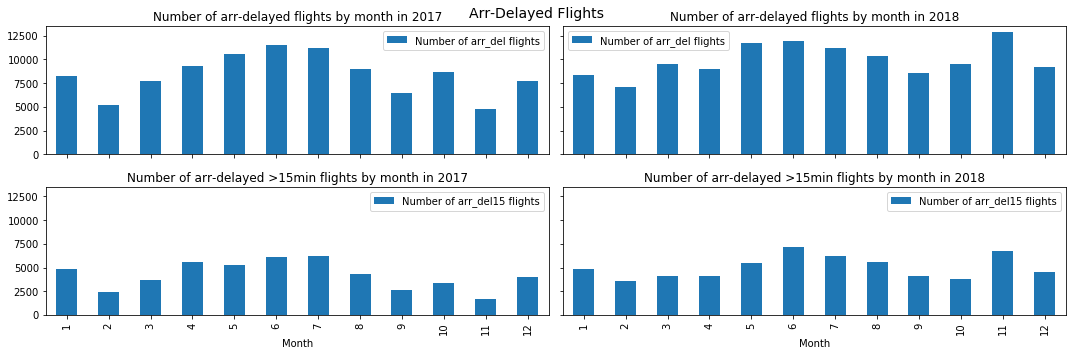

In [140]:
arr_del_count_2017 = flights_2017[flights_2017['IBTDelay'] > 0].groupby(['Month'])[['Year']].count().rename(
    columns={'Year': 'Number of arr_del flights'})
arr_del15_count_2017 = flights_2017[flights_2017['IBTDel15'] == 1].groupby(['Month'])[['Year']].count().rename(
    columns={'Year': 'Number of arr_del15 flights'})
arr_del_count_2018 = flights_2018[flights_2018['IBTDelay'] > 0].groupby(['Month'])[['Year']].count().rename(
    columns={'Year': 'Number of arr_del flights'})
arr_del15_count_2018 = flights_2018[flights_2018['IBTDel15'] == 1].groupby(['Month'])[['Year']].count().rename(
    columns={'Year': 'Number of arr_del15 flights'})

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(15, 5))
fig.suptitle('Arr-Delayed Flights', fontsize=14)
arr_del_count_2017.plot.bar(ax=axes[0, 0], subplots=True)
arr_del15_count_2017.plot.bar(ax=axes[1, 0], subplots=True)
arr_del_count_2018.plot.bar(ax=axes[0, 1], subplots=True)
arr_del15_count_2018.plot.bar(ax=axes[1, 1], subplots=True)

axes[0, 0].title.set_text('Number of arr-delayed flights by month in 2017')
axes[1, 0].title.set_text(
    'Number of arr-delayed >15min flights by month in 2017')
axes[0, 1].title.set_text('Number of arr-delayed flights by month in 2018')
axes[1, 1].title.set_text(
    'Number of arr-delayed >15min flights by month in 2018')

plt.tight_layout()

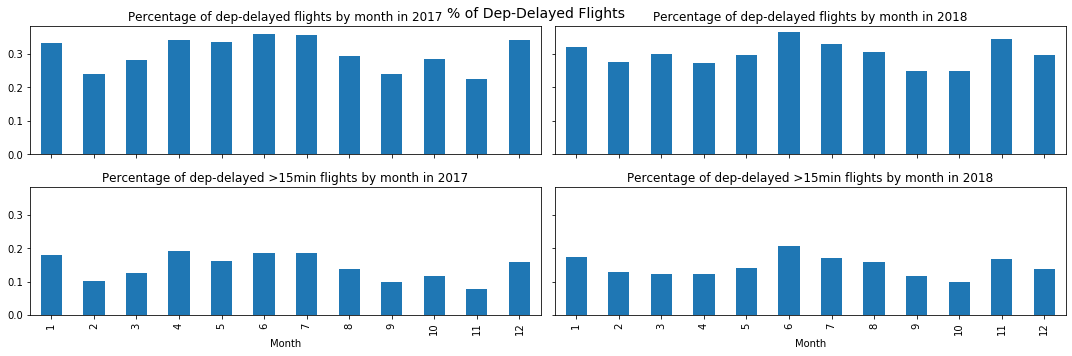

In [137]:
flights_2017_month = flights_2017.groupby(['Month'])[['Year']].count().rename(columns={'Year': 'Number of flights'})
perc_del_2017_month = dep_del_count_2017['Number of dep_del flights'] / flights_2017_month['Number of flights']
perc_del15_2017_month = dep_del15_count_2017['Number of dep_del15 flights'] / flights_2017_month['Number of flights']

flights_2018_month = flights_2018.groupby(['Month'])[['Year']].count().rename(columns={'Year': 'Number of flights'})
perc_del_2018_month = dep_del_count_2018['Number of dep_del flights'] / flights_2018_month['Number of flights']
perc_del15_2018_month = dep_del15_count_2018['Number of dep_del15 flights'] / flights_2018_month['Number of flights']

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(15, 5))
fig.suptitle('% of Dep-Delayed Flights', fontsize=14)
perc_del_2017_month.plot.bar(ax=axes[0, 0], subplots=True)
perc_del15_2017_month.plot.bar(ax=axes[1, 0], subplots=True)
perc_del_2018_month.plot.bar(ax=axes[0, 1], subplots=True)
perc_del15_2018_month.plot.bar(ax=axes[1, 1], subplots=True)

axes[0, 0].title.set_text('Percentage of dep-delayed flights by month in 2017')
axes[1, 0].title.set_text(
    'Percentage of dep-delayed >15min flights by month in 2017')
axes[0, 1].title.set_text('Percentage of dep-delayed flights by month in 2018')
axes[1, 1].title.set_text(
    'Percentage of dep-delayed >15min flights by month in 2018')

plt.tight_layout()

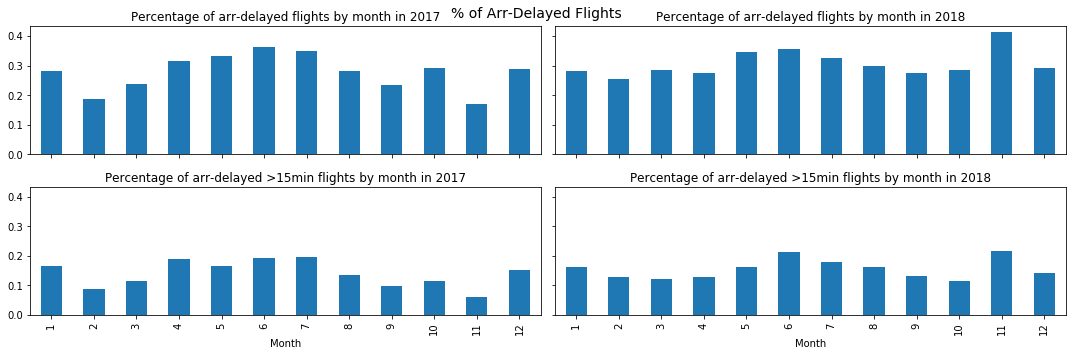

In [142]:
perc_arr_2017_month = arr_del_count_2017['Number of arr_del flights'] / flights_2017_month['Number of flights']
perc_arr15_2017_month = arr_del15_count_2017['Number of arr_del15 flights'] / flights_2017_month['Number of flights']

perc_arr_2018_month = arr_del_count_2018['Number of arr_del flights'] / flights_2018_month['Number of flights']
perc_arr15_2018_month = arr_del15_count_2018['Number of arr_del15 flights'] / flights_2018_month['Number of flights']

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(15, 5))
fig.suptitle('% of Arr-Delayed Flights', fontsize=14)
perc_arr_2017_month.plot.bar(ax=axes[0, 0], subplots=True)
perc_arr15_2017_month.plot.bar(ax=axes[1, 0], subplots=True)
perc_arr_2018_month.plot.bar(ax=axes[0, 1], subplots=True)
perc_arr15_2018_month.plot.bar(ax=axes[1, 1], subplots=True)

axes[0, 0].title.set_text('Percentage of arr-delayed flights by month in 2017')
axes[1, 0].title.set_text(
    'Percentage of arr-delayed >15min flights by month in 2017')
axes[0, 1].title.set_text('Percentage of arr-delayed flights by month in 2018')
axes[1, 1].title.set_text(
    'Percentage of arr-delayed >15min flights by month in 2018')

plt.tight_layout()

Note that only when Arrival Delay is longer than 15 minutes there's data about what caused the delay. Arrival Delay is the sum of CarrierDelay, WeatherDelay, NASDelay and LateAircraftDelay. 
More often than not, airports and carriers allocate a CRSElapsedTime higher than the actual time spent in the Taxi In + Taxi out + Airtime operations (Actual Elapsed Time). This is the reason why, when planes take off on time, landing usually takes place before the expected time! It also allows to absorb delay by late aircraft down the lane of chained flights.
(to verify statements)

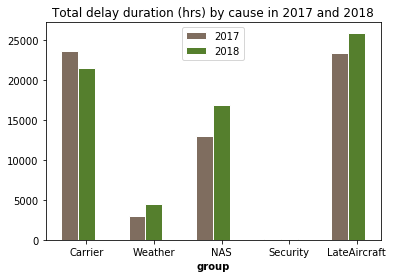

In [164]:
# construct df
carrier_delay_2017 = flights_2017['CarrierDelay'].sum() / 60
weather_delay_2017 = flights_2017['WeatherDelay'].sum() / 60
NAS_delay_2017 = flights_2017['NASDelay'].sum() / 60
security_delay_2017 = flights_2017['SecurityDelay'].sum() / 60
late_aircraft_delay_2017 = flights_2017['LateAircraftDelay'].sum() / 60

carrier_delay_2018 = flights_2018['CarrierDelay'].sum() / 60
weather_delay_2018 = flights_2018['WeatherDelay'].sum() / 60
NAS_delay_2018 = flights_2018['NASDelay'].sum() / 60
security_delay_2018 = flights_2018['SecurityDelay'].sum() / 60
late_aircraft_delay_2018 = flights_2018['LateAircraftDelay'].sum() / 60

delays = {'DelayCause': ['Carrier', 'Weather', 'NAS', 'Security', 'LateAircraft'],
          'TotalDelay2017_hr': [carrier_delay_2017, weather_delay_2017, NAS_delay_2017, security_delay_2017, late_aircraft_delay_2017],
          'TotalDelay2018_hr': [carrier_delay_2018, weather_delay_2018, NAS_delay_2018, security_delay_2018, late_aircraft_delay_2018]
          }

delay_df = pd.DataFrame(
    delays, columns=['DelayCause', 'TotalDelay2017_hr', 'TotalDelay2018_hr'])

delay_df.set_index('DelayCause')

# plot the graph

# set width of bar
barWidth = 0.25

# set height of bar
bars1 = delay_df['TotalDelay2017_hr']
bars2 = delay_df['TotalDelay2018_hr']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth,
        edgecolor='white', label='var1')
plt.bar(r2, bars2, color='#557f2d', width=barWidth,
        edgecolor='white', label='var2')

# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))],
           ['Carrier', 'Weather', 'NAS', 'Security', 'LateAircraft'])

# Create legend & Show graphic
plt.legend(['2017', '2018'])
plt.title('Total delay duration (hrs) by cause in 2017 and 2018')
plt.show()

NAS stands for National Airspace System.

## Correlation between scheduled and actual flight duration

Text(0.5, 1.0, 'Actual flight duration VS scheduled flight duration')

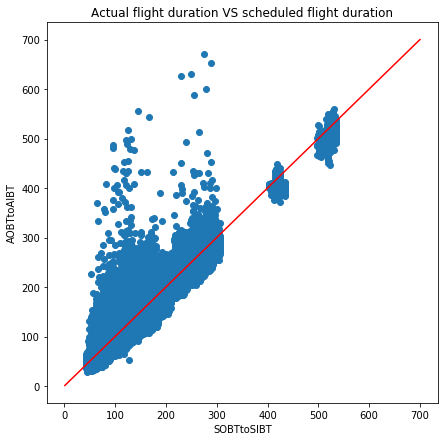

In [189]:
plt.rcParams["figure.figsize"] = (7, 7)
plt.scatter(flights['SOBTtoSIBT'], flights['AOBTtoAIBT'])
plt.plot([1, 350, 700],[1, 350, 700], color='r')
plt.xlabel('SOBTtoSIBT')
plt.ylabel('AOBTtoAIBT')
plt.title('Actual flight duration VS scheduled flight duration')

In [197]:
corr, _ = pearsonr(flights['SOBTtoSIBT'], flights['AOBTtoAIBT'])
print('Pearsons correlation between SOBTtoSIBT and AOBTtoAIBT: %.3f' % corr)

Pearsons correlation between SOBTtoSIBT and AOBTtoAIBT: 0.968


## Correlation between all features

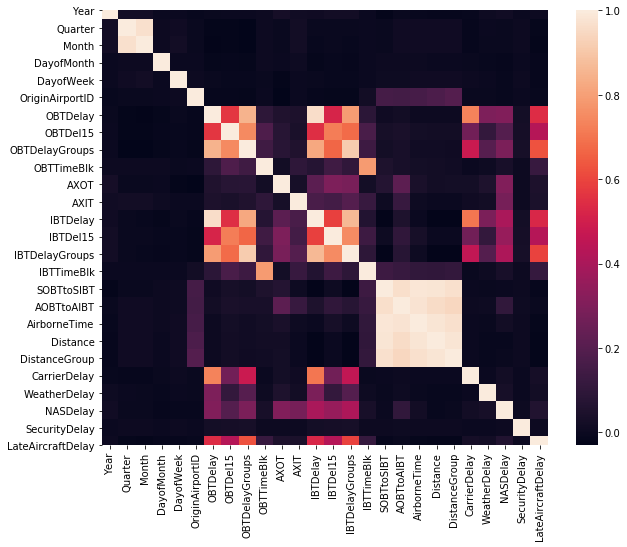

In [231]:
f, ax = plt.subplots(figsize=(10, 8))
corr = flights.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Correlation between scheduled flight duration and distance

Text(0.5, 1.0, 'Distance VS scheduled flight duration')

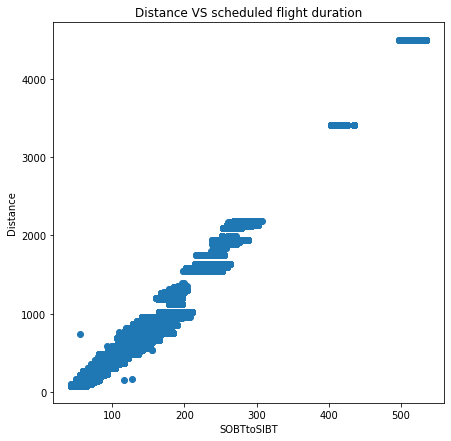

In [196]:
plt.rcParams["figure.figsize"] = (7, 7)
plt.scatter(flights['SOBTtoSIBT'], flights['Distance'])
plt.xlabel('SOBTtoSIBT')
plt.ylabel('Distance')
plt.title('Distance VS scheduled flight duration')

In [198]:
corr, _ = pearsonr(flights['SOBTtoSIBT'], flights['Distance'])
print('Pearsons correlation between SOBTtoSIBT and Flight Distance: %.3f' % corr)

Pearsons correlation between SOBTtoSIBT and Flight Distance: 0.981


## Number of arrivals by flight type
* Short Haul - Distance < 800 miles
* Medium Haul - Distance 800 and 2200 miles (inclusive)
* Long Haul - Distance > 2200miles
Source: wiki page of Flight length

In [233]:
flights['FlightType'] = 'ShortHaul'
flights.loc[(flights['Distance'] >= 800) & (
    flights['Distance'] <= 2200), 'FlightType'] = 'MediumHaul'
flights.loc[(flights['Distance'] > 2200), 'FlightType'] = 'LongHaul'

df_flight = pd.DataFrame(flights['FlightType'].value_counts().reset_index().values, 
                         columns=["FlightType", "Number of Arrivals"])

labels = ["Short Haul", "Medium Haul", "Long Haul"]
value = [df_flight['Number of Arrivals'][0],
         df_flight['Number of Arrivals'][1],
         df_flight['Number of Arrivals'][2]]
# colors=['lightcyan','cyan','royalblue']

figs = go.Figure(data=[go.Pie(labels=labels, 
                              values=value, 
                              pull=[0, 0, 0.3], 
                              textinfo='label+percent', 
                              hole=0.4, 
                              hoverinfo="label+percent")])
figs.update_traces(textinfo='label+percent', textfont_size=10)
figs.update_layout(
    title_text="<b>Flights By Distance<b> <i>(in Miles)<i>", 
    title_x=0.5, 
    font_size=12, 
    legend=dict(x=.75, y=0.55),
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='<b>Distance<b>', x=0.5, y=0.5, font_size=11, showarrow=False)]
)
figs.show()

## The 10 longest routes

In [227]:
# longest air routes
temp = flights[['OriginCityName', 'Distance']].drop_duplicates()
temp = temp.sort_values('Distance', ascending=False)
temp['DestCityName'] = 'Atlanta'
longest_10_routes = temp.head(10).values.tolist()
longest_10_routes

[['Honolulu, HI', 4502, 'Atlanta'],
 ['Anchorage, AK', 3417, 'Atlanta'],
 ['Seattle, WA', 2182, 'Atlanta'],
 ['Portland, OR', 2172, 'Atlanta'],
 ['San Francisco, CA', 2139, 'Atlanta'],
 ['Oakland, CA', 2130, 'Atlanta'],
 ['San Jose, CA', 2116, 'Atlanta'],
 ['Sacramento, CA', 2092, 'Atlanta'],
 ['Reno, NV', 1993, 'Atlanta'],
 ['Los Angeles, CA', 1947, 'Atlanta']]

## The 10 shortest routes

In [228]:
# shortest Air Routes
temp = temp.sort_values('Distance', ascending=True)
temp = temp[['OriginCityName', 'DestCityName']]
longest_10_routes = temp.head(10).values.tolist()
longest_10_routes

[['Columbus, GA', 'Atlanta'],
 ['Chattanooga, TN', 'Atlanta'],
 ['Birmingham, AL', 'Atlanta'],
 ['Augusta, GA', 'Atlanta'],
 ['Albany, GA', 'Atlanta'],
 ['Montgomery, AL', 'Atlanta'],
 ['Huntsville, AL', 'Atlanta'],
 ['Knoxville, TN', 'Atlanta'],
 ['Greer, SC', 'Atlanta'],
 ['Asheville, NC', 'Atlanta']]

In [83]:
flights.head(3)

,Year,Quarter,Month,DayofMonth,DayofWeek,UniqueCarrierCode,OriginAirportID,OriginCityName,OriginStateName,SOBT,AOBT,OBTDelay,OBTDel15,OBTDelayGroups,OBTTimeBlk,AXOT,ATOT,ALDT,AXIT,SIBT,AIBT,IBTDelay,IBTDel15,IBTDelayGroups,IBTTimeBlk,SOBTtoSIBT,AOBTtoAIBT,AirborneTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2017,1,1,1,7,AA,11298,"Dallas/Fort Worth, TX",Texas,2017-01-01 14:25:00,2017-01-01 14:30:00,5,0,0,14,12,2017-01-01 14:42:00,2017-01-01 17:17:00,10,2017-01-01 17:26:00,2017-01-01 17:27:00,1,0,0,17,121,117,95,731,3,0,0,0,0,0
1,2017,1,1,2,1,AA,11298,"Dallas/Fort Worth, TX",Texas,2017-01-02 14:25:00,2017-01-02 14:20:00,-5,0,-1,14,13,2017-01-02 14:33:00,2017-01-02 17:23:00,11,2017-01-02 17:26:00,2017-01-02 17:34:00,8,0,0,17,121,134,110,731,3,0,0,0,0,0
2,2017,1,1,3,2,AA,11298,"Dallas/Fort Worth, TX",Texas,2017-01-03 14:25:00,2017-01-03 14:26:00,1,0,0,14,14,2017-01-03 14:40:00,2017-01-03 17:18:00,5,2017-01-03 17:26:00,2017-01-03 17:23:00,-3,0,-1,17,121,117,98,731,3,0,0,0,0,0
